In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as np
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(X_train,_),(_,_) = mnist.load_data()

(60000, 28, 28)


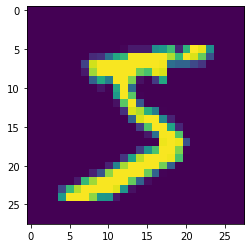

-1.0
1.0
(60000, 28, 28)


In [3]:
print(X_train.shape)
plt.imshow(X_train[0])
plt.show()
#Normalization
X_train = (X_train.astype('float32') - 127.5) / 127.5
print(np.min(X_train))
print(np.max(X_train))
print(X_train.shape) 

In [4]:
TOTAL_EPOCH = 5
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_train.shape[0]/BATCH_SIZE)
HALF_BATCH = 128
NOISE_DIM = 100
adam = Adam(lr = 2e-4, beta_1=0.5)

In [5]:
generator = Sequential()
generator.add(Dense(256, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss = 'binary_crossentropy',optimizer = adam)
generator.summary()

W1021 22:25:38.400754 140653490308928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1021 22:25:38.411400 140653490308928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 22:25:38.424287 140653490308928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1021 22:25:38.490736 140653490308928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1021 22:25:38.496869 140653490308928 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [6]:
descriminator = Sequential()
descriminator.add(Dense(512,input_shape = (784,)))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dense(256))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dense(1,activation = 'sigmoid'))
descriminator.compile(loss = 'binary_crossentropy',optimizer = adam)
descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


# Gan

In [7]:
descriminator.trainable = False
gan_input = Input(shape = (NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = descriminator(generated_img)

model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer = adam)

In [12]:
def save_imgs(epoch,samples = 100):
        noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
        generated_imgs = generator.predict(noise)
        generated_imgs = generated_imgs.reshape(samples,28,28)
        plt.figure(figsize = (100,100))
        for i in range(samples):
            plt.plot(50,50,i+1)
            plt.imshow(generated_imgs[i],interpolation = 'nearest',cmap='gray')
            plt.axis("off")
            plt.tight_layout()
            plt.savefig('images/gan_out_epoch{0}.png'.format(epoch+1))
            plt.show()
    

# Training Loop

In [13]:
X_train = X_train.reshape(-1, 784)
d_losses = []
g_losses = []
for epoch in range(TOTAL_EPOCH):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    for step in range(NO_OF_BATCHES):
        #Discriminator
        #50% real data + 50% Fake Data
        #Real Data
        idx = np.random.randint(0,X_train.shape[0],HALF_BATCH)
        real_imgs = X_train[idx]
        #Fake data
        noise = np.random.randint(0,1,size = (HALF_BATCH,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        #labels
        real_y = np.ones((HALF_BATCH,1))
        #One sided smoothing for descriminator 0.9
        fake_y = np.zeros((HALF_BATCH,1))
        
        #Train Descriminator
        d_loss_real = descriminator.train_on_batch(real_imgs,real_y)
        
        d_loss_fake = descriminator.train_on_batch(fake_imgs,fake_y)
        
        d_loss = 0.5 * d_loss_real + 0.5 * d_loss_fake
        
        epoch_d_loss += d_loss
        
        #Train Generator
        
        noise = np.random.normal(0,1,size = (BATCH_SIZE,NOISE_DIM))
        
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss += g_loss
        
    #print("Epoch %d Discriminator_loss %.4f Generator_loss %.4f"%((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    
    print("Epoch %d Discriminator_loss %.4f Generator_loss %.4f"%((epoch+1),epoch_d_loss,epoch_g_loss))
    #d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    d_losses.append(epoch_d_loss)
    
    g_losses.append(epoch_g_loss)
    #g_losses.append(epoch_g_loss/NO_OF_BATCHES)
def save_imgs(epoch,samples = 100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    plt.figure(figsize = (100,100))
    for i in range(samples):
        plt.plot(50,50,i+1)
        plt.imshow(generated_imgs[i],interpolation = 'nearest',cmap='gray')
        plt.axis("off")
        plt.tight_layout()
        plt.savefig('images/gan_out_epoch{0}.png'.format(epoch+1))
        plt.show()

if(epoch+1) % 10 == 0:
    generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
    save_imgs(epoch)



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Discriminator_loss 0.0279 Generator_loss 0.0241
Epoch 2 Discriminator_loss 0.0146 Generator_loss 0.0161
Epoch 3 Discriminator_loss 0.0159 Generator_loss 0.0165
Epoch 4 Discriminator_loss 0.0069 Generator_loss 0.0064
Epoch 5 Discriminator_loss 0.0047 Generator_loss 0.0053


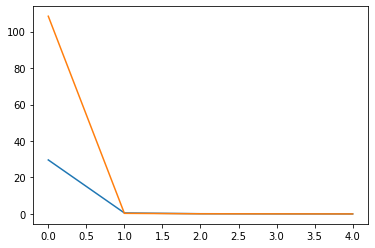

In [10]:
plt.plot(d_losses,label="DISC")
plt.plot(g_losses, label="GEN")
plt.show()